#                    Refference 
       http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [26]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
from statsmodels.graphics.tsaplots import *

import matplotlib.pyplot as plt
import matplotlib as mpl

In [177]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (4, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0),colspan=2)
        pacf_ax = plt.subplot2grid(layout, (2, 0),colspan=2)
        qq_ax = plt.subplot2grid(layout, (3, 0))
        pp_ax = plt.subplot2grid(layout, (3, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        #QQ-Plot and Probability-Plot 確認常態分佈
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [30]:
stock = pd.read_csv("./stocklist/8446_stockinfo.csv",index_col="date")


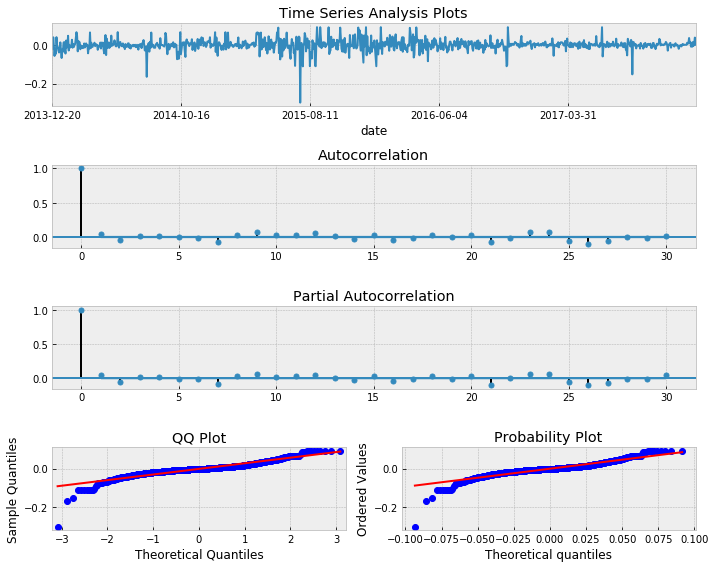

In [178]:
st_train = stock.close[:1000]
priceret = st_train.diff(1)/st_train
priceret = priceret.dropna()
tsplot(priceret,lags=30)
# tsplot(st_train,lags=30)
plt.show()

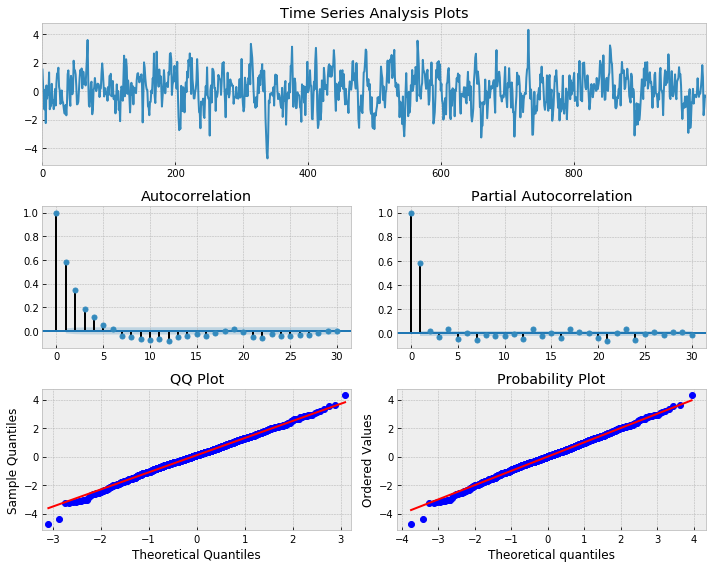

In [53]:
# Simulate an AR(1) process with alpha = 0.6,P=1的情況:先做出P=1的time series再用它畫圖

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
tsplot(x, lags=30)
plt.show()

In [18]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))


alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


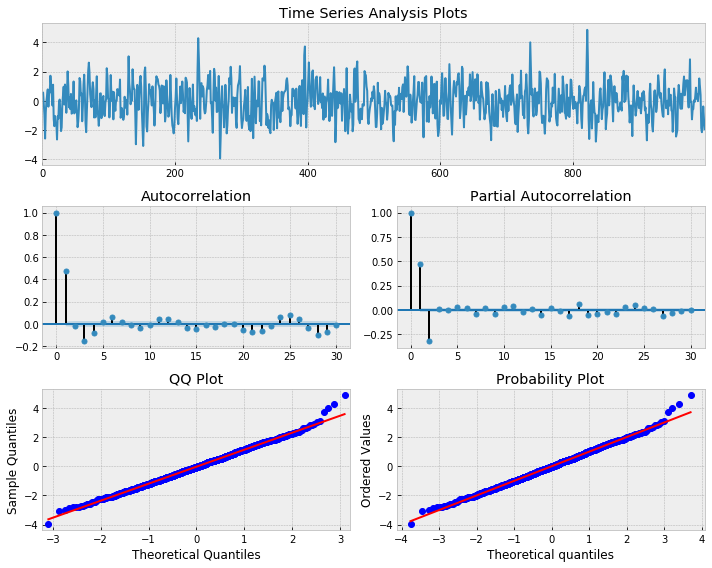

In [20]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ar2, lags=30)
plt.show()

In [68]:
# Select best lag order for stock8446 returns

max_lag = 30
mdl = smt.AR(priceret).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(priceret).select_order(maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = {}'.format(est_order))


/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best estimated lag order = 27


The best order is 27 lags or 27 parameters! Any model with this many parameters is unlikely to be useful in practice. Clearly there is more complexity underlying the returns process than this model can explain.落後期數太多會導致模型預測不太可能有用

In [21]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(mdl.params[0],mdl.params[1], est_order))
print('\ntrue coefs = {} | true order = {}'.format([.666,-.333], true_order))


coef estimate: 0.6291 -0.3196 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


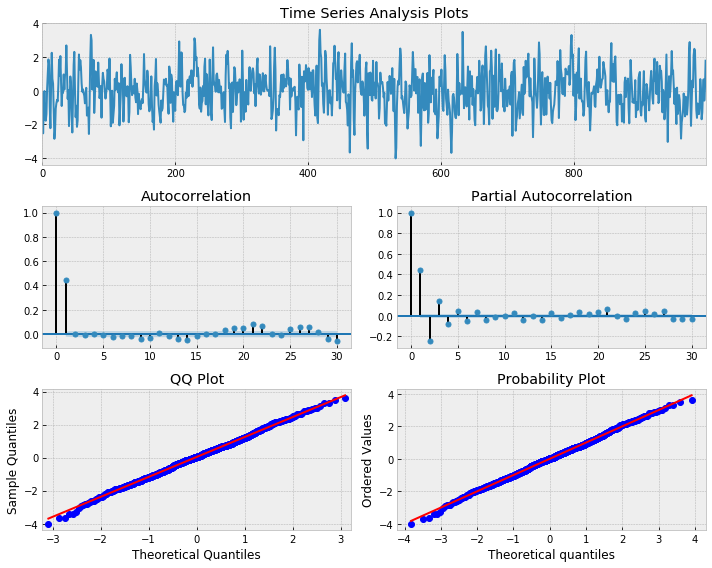

In [60]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ma1, lags=30)
plt.show()

In [63]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1448.721
Method:                           mle   S.D. of innovations              1.030
Date:                Mon, 11 Feb 2019   AIC                           2901.441
Time:                        16:36:51   BIC                           2911.257
Sample:                             0   HQIC                          2905.172
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6158      0.026     23.947      0.000       0.565       0.666
                                    Roots                                    
                  Real          Imaginary           M

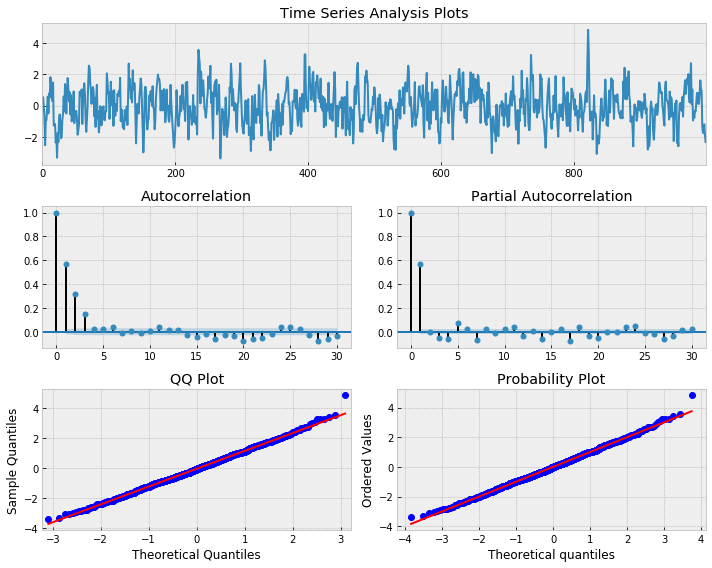

In [64]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
tsplot(ma3, lags=30)
plt.show()

In [65]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1389.808
Method:                           mle   S.D. of innovations              0.971
Date:                Mon, 11 Feb 2019   AIC                           2787.616
Time:                        22:09:23   BIC                           2807.247
Sample:                             0   HQIC                          2795.077
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5673      0.031     18.393      0.000       0.507       0.628
ma.L2.y        0.3662      0.034     10.621      0.000       0.299       0.434
ma.L3.y        0.1966      0.030      6.539      0.0

aic: 14146.00016 | order: (3, 2)


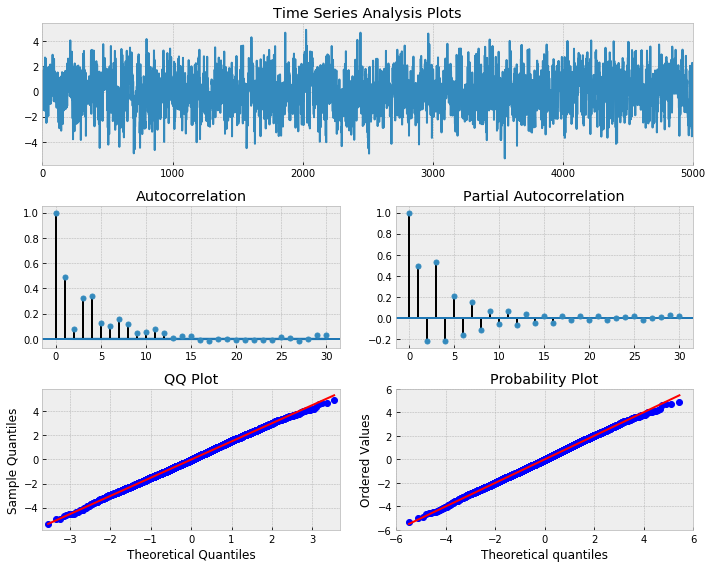

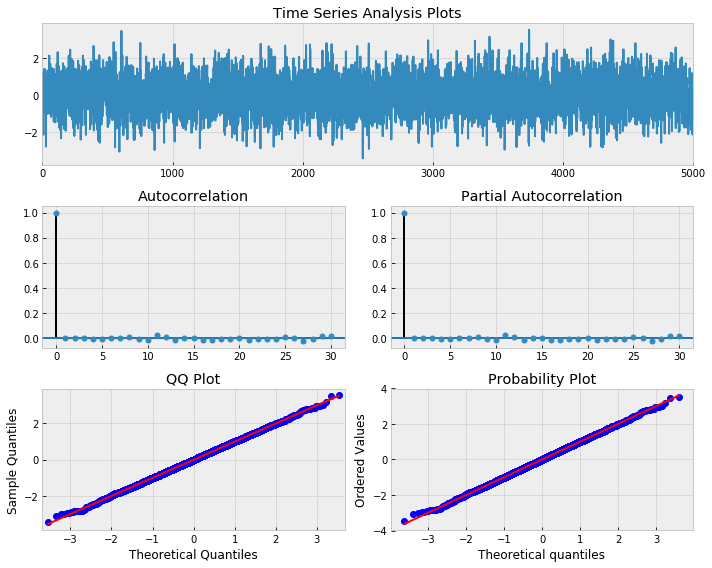

In [37]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
tsplot(tmp_mdl.resid,lags=30)

# aic: 14108.27213 | order: (3, 2)


plt.show()


In [70]:
# Fit ARMA model to stockprice returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(priceret, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has

aic: -4246.95225 | order: (3, 2)


/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has

/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has

/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ray/.pyenv/versions/3.5.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has

aic: -4246.95225 | order: (3, 0, 2)


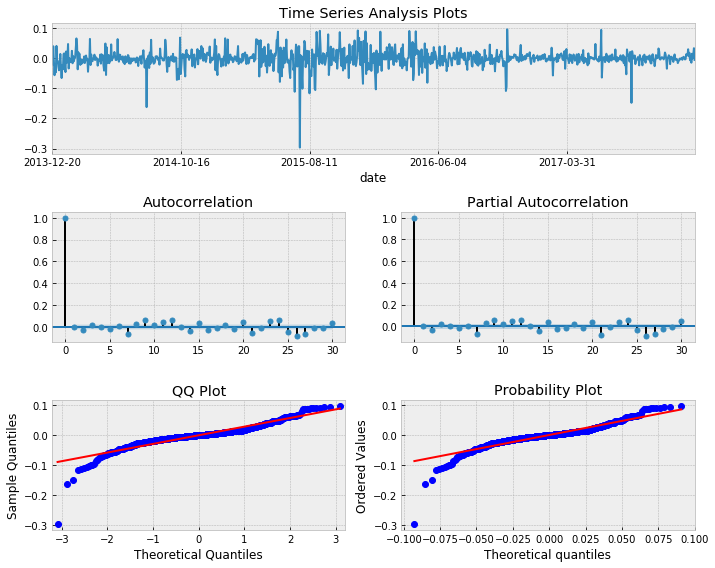

In [32]:
# Fit ARIMA(p, d, q) model to stockprice Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(priceret, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
tsplot(best_mdl.resid, lags=30)
plt.show()

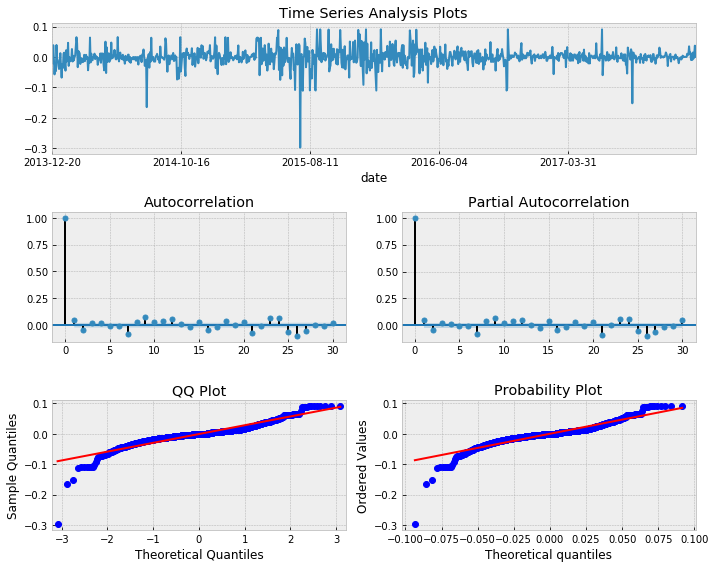

In [36]:
tsplot(priceret,lags=30)
plt.show()

In [103]:
# Create a 21 day forecast of stockprice returns with 95%, 99% CI
n_steps = 21

f, err95, confidence_interval95 = best_mdl.forecast(steps=n_steps) # 95% confidence_interval
_, err99, confidence_interval99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% confidence_interval


idx = pd.date_range(priceret.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, confidence_interval95]),index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([confidence_interval99]),index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()


,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2018-01-12,-0.558717,-2.507378,-3.119691,1.389944,2.002258
2018-01-13,-0.720205,-3.441394,-4.296454,2.000985,2.856045
2018-01-14,-0.388093,-3.111340,-3.967046,2.335155,3.190861
2018-01-15,-0.252717,-2.991071,-3.851525,2.485637,3.346091
2018-01-16,-0.320871,-3.204902,-4.111131,2.563161,3.469390


In [170]:
## predict function is not useful , this block if fail 
# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = priceret.iloc[-500:].copy()
print(ts.index[0],type(ts.index[-1]))
ts.plot(ax=ax, label='8446 Returns')
# in sample prediction
pred = best_mdl.predict(2018-1-31,2018-1-12)
pred.cumsum()
print(pred)
pred.plot(ax=ax, style='r-', label='In-sample prediction')

# styles = ['b-', '0.2', '0.75', '0.2', '0.75']
# fc_all.plot(ax=ax, style=styles)
# plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
# plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
# plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
# plt.legend(loc='best', fontsize=10)

plt.show()

2015-12-31 <class 'str'>
[-0.44585069 -1.36432727  0.94631915  0.23207973 -0.4225716   0.83345957
  1.66134461 -0.69412673 -1.35221793  0.69392617 -0.58108869 -2.27851992
 -0.22620952 -0.76077344 -2.23672036 -0.14772222  0.0400582  -0.71782235
 -0.42870036  0.84196708]


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [137]:
def date_modify(date):
    year = date.split('-')[0]
    month = date.split('-')[1]
    day = date.split('-')[-1]
    if int(month) <10:
        month = month[-1]
    if int(day) < 10:
        day = day[-1]
    date = year+'-'+month+'-'+day
    return str(date)


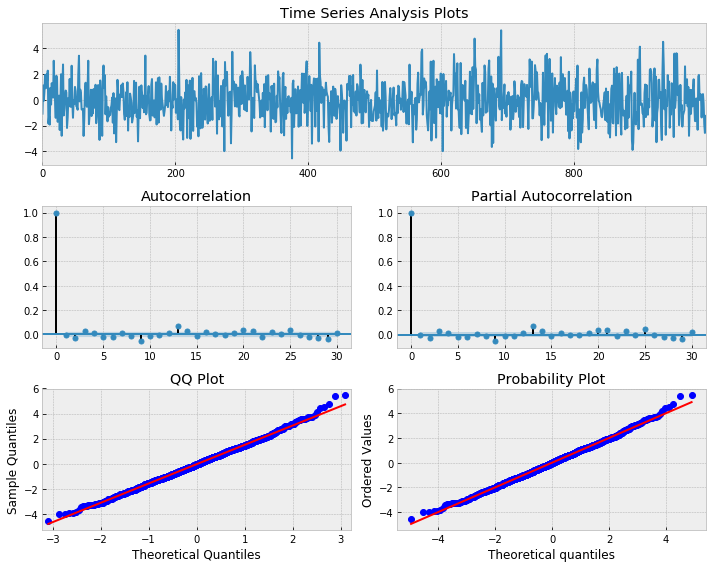

In [175]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
# Y = Y**2 #SIMULATED ARCH(1)**2 PROCESS
tsplot(Y, lags=30)
plt.show()

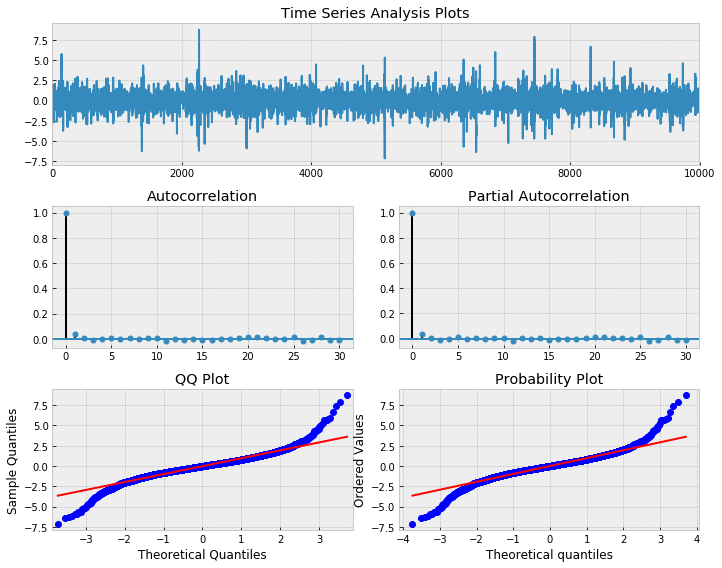

In [176]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps, lags=30)
plt.show()